In [5]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

1/1 [==============================] - 0s 378ms/step


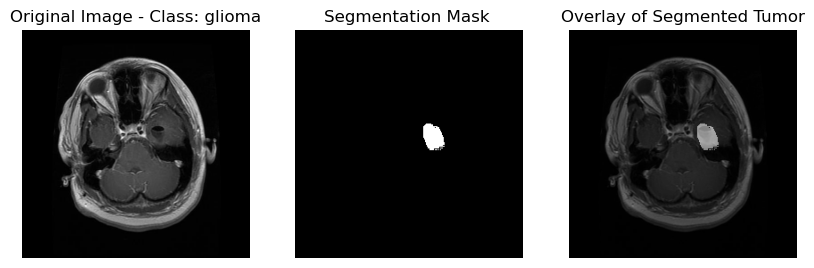

In [11]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Load the classification model
class_model = load_model('EfficinetB0_Brain1.keras')

# Load the segmentation model with the custom dice coefficient metric function
seg_model = load_model('Unet_mri_segmentation_model.h5', custom_objects={'dice_coef': dice_coef})

# Load and preprocess the MRI image
img_path = r"F:\brain tumor\Testing\glioma\Te-gl_0050.jpg"
original_image = cv2.imread(img_path)  # Read with default color mode
original_image_resized_for_class = cv2.resize(original_image, (224, 224))

# Preprocess the image for classification
class_img_array = image.img_to_array(original_image_resized_for_class)
class_img_array = np.expand_dims(class_img_array, axis=0)
class_img_array = preprocess_input(class_img_array)  # Normalize 

# Predict the class
class_predictions = class_model.predict(class_img_array)
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
predicted_class = class_labels[np.argmax(class_predictions)]

# If the predicted class is not 'notumor', proceed to segmentation
if predicted_class != 'notumor':
    original_image_resized_for_seg = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    original_image_resized_for_seg = cv2.resize(original_image_resized_for_seg, (256, 256))
    seg_img_array = np.expand_dims(original_image_resized_for_seg, axis=[0, -1])
    seg_img_array = seg_img_array / 255.0  # Normalize if model was trained with normalized data

    # Predict the segmentation mask
    predicted_mask = seg_model.predict(seg_img_array)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)[0, :, :, 0]

# Visualization
if predicted_class == 'notumor':
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image - Class: {predicted_class}')
    plt.axis('off')
    plt.show()
else:
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    # Original image with class prediction
    axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f'Original Image - Class: {predicted_class}')
    axs[0].axis('off')

    # Segmentation mask only
    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].set_title('Segmentation Mask ')
    axs[1].axis('off')
    
    # Overlay of segmentation mask on the original grayscale image
    axs[2].imshow(original_image_resized_for_seg, cmap='gray')
    axs[2].imshow(predicted_mask, cmap='gray', alpha=0.5)
    axs[2].set_title('Overlay of Segmented Tumor')
    axs[2].axis('off')


    plt.show()


In [ ]:
#Classification using EfficientnetB0+DenseNet121+vgg19 and segmenatation using unet model 

In [4]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet



In [5]:
# Define the dice coefficient metric for the segmentation model
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Function to load and preprocess the image for each model
def preprocess_image(img_path, preprocess_function, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_function(img)
    return img



In [6]:
# Load the models
model1 = load_model("EfficinetB0_Brain1.keras")  # EfficientNetB0
model4 = load_model("VGG19_Brain.keras")         # VGG19
model5 = load_model("DenseNet121_Brain.keras")   # DenseNet121



In [21]:
# Path to your MRI image
img_path = r"D:\Brain\Brain Tumor\test\notumor\Te-no_0238.jpg"

# Preprocess the image for each model
img1 = preprocess_image(img_path, preprocess_efficientnet)
img4 = preprocess_image(img_path, preprocess_vgg19)
img5 = preprocess_image(img_path, preprocess_densenet)

# Predict with each model
pred1 = model1.predict(img1)
pred4 = model4.predict(img4)
pred5 = model5.predict(img5)

# Weights for each model, adjust based on their validation accuracy
weights = np.array([0.5, 0.2, 0.3])

# Calculate weighted sum of probabilities for soft voting
weighted_predictions = (pred1 * weights[0] + pred4 * weights[1] + pred5 * weights[2])

# Determine final predicted class
predicted_class_index = np.argmax(weighted_predictions, axis=1)[0]
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
predicted_class = class_labels[predicted_class_index]



1/1 [==============================] - 0s 79ms/step


No tumor detected in this MRI


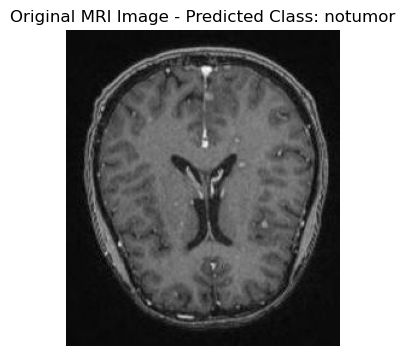

In [26]:
# Load the segmentation model if needed
if predicted_class != 'notumor':
    seg_model = load_model('Unet_mri_segmentation_model.h5', custom_objects={'dice_coef': dice_coef})

    # Assuming the segmentation model expects grayscale images
    original_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    original_image_resized = cv2.resize(original_image, (256, 256))
    seg_img_array = np.expand_dims(original_image_resized, axis=0)
    seg_img_array = seg_img_array / 255.0  # Normalizing

    # Predict the segmentation mask
    predicted_mask = seg_model.predict(seg_img_array)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)[0, :, :, 0]

    # Visualization of results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f'Original MRI Image - Predicted Class: {predicted_class}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image_resized, cmap='gray')
    plt.imshow(predicted_mask, cmap='gray', alpha=0.5)
    plt.title('Overlay of Segmented Tumor')
    plt.axis('off')

    plt.show()
else:
    print(f"No tumor detected in this MRI")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(f'Original MRI Image - Predicted Class: {predicted_class}')
    plt.axis('off')


1/1 [==============================] - 0s 449ms/step


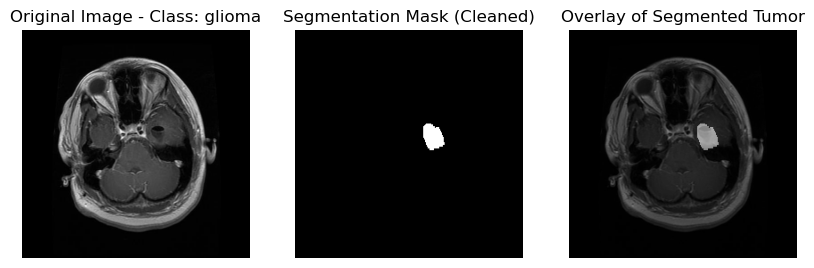

In [2]:
import numpy as np
import cv2
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Load the classification model
class_model = load_model('EfficinetB0_Brain1.keras')

# Load the segmentation model with the custom dice coefficient metric function
seg_model = load_model('Unet_mri_segmentation_model.h5', custom_objects={'dice_coef': dice_coef})

# Load and preprocess the MRI image
img_path = r"F:\brain tumor\Testing\glioma\Te-gl_0050.jpg"
original_image = cv2.imread(img_path)  # Read with default color mode
original_image_resized_for_class = cv2.resize(original_image, (224, 224))

# Preprocess the image for classification
class_img_array = image.img_to_array(original_image_resized_for_class)
class_img_array = np.expand_dims(class_img_array, axis=0)
class_img_array = preprocess_input(class_img_array)  # Normalize 

# Predict the class
class_predictions = class_model.predict(class_img_array)
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
predicted_class = class_labels[np.argmax(class_predictions)]

# If the predicted class is not 'notumor', proceed to segmentation
if predicted_class != 'notumor':
    original_image_resized_for_seg = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    original_image_resized_for_seg = cv2.resize(original_image_resized_for_seg, (256, 256))
    seg_img_array = np.expand_dims(original_image_resized_for_seg, axis=[0, -1])
    seg_img_array = seg_img_array / 255.0  # Normalize if model was trained with normalized data

    # Predict the segmentation mask
    predicted_mask = seg_model.predict(seg_img_array)
    
    # Post-processing
    threshold = 0.5
    binarized_mask = (predicted_mask > threshold).astype(np.uint8)  # Thresholding
    kernel = np.ones((3, 3), np.uint8)
    cleaned_mask = cv2.morphologyEx(binarized_mask[0, :, :, 0], cv2.MORPH_OPEN, kernel)  # Morphological opening

# Visualization
if predicted_class == 'notumor':
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image - Class: {predicted_class}')
    plt.axis('off')
    plt.show()
else:
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    # Original image with class prediction
    axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f'Original Image - Class: {predicted_class}')
    axs[0].axis('off')

    # Segmentation mask only
    axs[1].imshow(cleaned_mask, cmap='gray')
    axs[1].set_title('Segmentation Mask (Cleaned)')
    axs[1].axis('off')
    
    # Overlay of segmentation mask on the original grayscale image
    axs[2].imshow(original_image_resized_for_seg, cmap='gray')
    axs[2].imshow(cleaned_mask, cmap='gray', alpha=0.5)
    axs[2].set_title('Overlay of Segmented Tumor')
    axs[2].axis('off')

    plt.show()
